In [1]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap

from kuaizi.display import display_single
from astropy.io import fits
from astropy.table import Table, hstack

## Try gaap with reference catalog

In [4]:
# Load Merian catalog as reference
# filt = 'i'
filt = 'N708'
tract = 9813
patch = 23
patch_old = f'{patch % 9},{patch // 9}'

# repo = '/projects/HSC/repo/main'
# collection = 'HSC/runs/RC2/w_2022_40/DM-36151'
# instr = 'HSC'
repo = '/projects/MERIAN/repo/'
collection = 'DECam/runs/merian/dr1_wide'
instr = 'DECam'

import lsst.daf.butler as dafButler
butler = dafButler.Butler(repo)
dataId = dict(tract=tract, patch=patch, band=filt)

refCat = butler.get(
    'deepCoadd_forced_src',
    collections=collection,
    dataId=dataId,
    instrument=instr,
    skymap='hsc_rings_v1',
)[:10] #[0:8358:8357]

refExposure = butler.get(
    'deepCoadd_calexp',
    collections=collection,
    dataId=dataId,
    instrument=instr,
    skymap='hsc_rings_v1',
)

refCatInBand = butler.get(
    'deepCoadd_ref',
    collections=collection,
    dataId=dataId,
    instrument=instr,
    skymap='hsc_rings_v1',
)[:10] #[0:8358:8357]

# refCatInBand = lsst.afw.table.SourceCatalog.readFits(
#     '/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/5,3/deblendedFlux-HSC-G-9813-5,3.fits')

expID = dict(tract=tract, patch=patch, band=filt, skymap='hsc_rings_v1')

In [5]:
# np.where(refCat['parent'] == 3495901618560303105)

In [6]:
hsc_type = 'w04'

if hsc_type == 'w40':
    exposure = lsst.afw.image.ExposureF(
        f'/scratch/arunj/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_40_DM-36356_20221006T193226Z.fits'
    )
elif hsc_type == 'w04':
    exposure = lsst.afw.image.ExposureF(
        f"/projects/MERIAN/repo/HSC/runs/RC2/w_2022_04/DM-33402/20220128T212035Z/deepCoadd_calexp/9813/{patch}/i/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_04_DM-33402_20220128T212035Z.fits"
    )
elif hsc_type == 'S20A':
    exposure = lsst.afw.image.ExposureF(
        f"/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/{patch_old}/calexp-HSC-I-{tract}-{patch_old}.fits"
    )

rsync -zva --progress jiaxuanl@tiger.princeton.edu://projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/5,3/calexp-HSC-I-9813-5,3.fits ./

In [14]:
measureConfig = lsst.meas.base.ForcedPhotCoaddConfig()
measureConfig.footprintDatasetName = 'DeblendedFlux'

# measureConfig.measurement.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.measurement.plugins.names.add("base_SdssShape")
measureConfig.measurement.plugins.names.add("base_GaussianFlux")
measureConfig.measurement.plugins.names.add("base_PsfFlux")
measureConfig.measurement.plugins.names.add("base_SdssCentroid")
# measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
# measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
# measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doOptimalPhotometry = True
# measureConfig.measurement.plugins["ext_gaap_GaapFlux"].sigmas = [0.5, 0.75, 1.0, 1.5, 2.0]

photTask = lsst.meas.base.ForcedPhotCoaddTask(refSchema=refCat.schema, config=measureConfig)
photTask.log.setLevel('TRACE')

In [15]:
measCat, exposureID = photTask.generateMeasCat(exposureDataId=butler.registry.expandDataId(expID), 
                                               exposure=exposure, 
                                               refCat=refCat, 
                                               refCatInBand=refCatInBand, 
                                               refWcs=refExposure.wcs, 
                                               idPackerName='tract_patch', 
                                               footprintData=refCatInBand)

In [16]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
photTask.run(measCat, exposure, refCat=refCat, refWcs=refExposure.wcs, exposureId=exposureID)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))
cat2 = measCat.copy(deep=True).asAstropy()

# Starting the measureTask at  Tue Nov 22 16:26:05 2022
# Finished measureTask in 0.64 seconds.


In [100]:
# refCat['id'] == 3495901618560303105

In [ ]:
## Now it's using Merian footprints on RC2 w40.

In [133]:
def writeObjectTable(measCat, band='i', save=True):
    import astropy.units as u
    from astropy.table import QTable
    
    outCat = measCat.copy(deep=True).asAstropy()
    outCat['coord_ra'] = outCat['coord_ra'].to(u.deg)
    outCat['coord_dec'] = outCat['coord_dec'].to(u.deg)

    old_gaap_cols = [
        item for item in measCat.schema.getNames() if ('gaap' in item and 'apCorr' not in item) | ('base_PsfFlux_instFlux' in item) | ('base_CircularApertureFlux' in item)]
    outCat = outCat[['id', 'coord_ra', 'coord_dec'] + old_gaap_cols]
    
    # PhotCalib
    for col in old_gaap_cols:
        if 'instFlux' in col:
            outCat[col] = outCat[col].value * \
                exposure.getPhotoCalib().instFluxToNanojansky(1) * u.nanomaggy

    new_gaap_cols = []
    for col in old_gaap_cols:
        name = col.replace('ext_gaap_GaapFlux', f'{band}_gaap')
        name = name.replace('_instFlux', 'Flux').replace('PsfFlux', 'Psf')
        if 'Flux' in name:
            aper = name.split(
                "x_")[-1].replace('FluxErr', '').replace('Flux', '')
            name = name.replace('_1_15x', '')
            name = name.replace('_' + aper, aper.replace('_', 'p'))

        if 'flag' in name:
            aper = name.split(
                "x_")[-1].replace('_flag_bigPsf', '').replace('_flag', '')
            name = name.replace('_1_15x', '')
            if not 'gauss' in name:
                name = name.replace(
                    '_' + aper, aper.replace('_', 'p') + 'Flux')
        new_gaap_cols.append(name)
    
    outCat.rename_columns(old_gaap_cols, new_gaap_cols)
    outCat = QTable(outCat)
    return outCat

In [134]:
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [135]:
from hsc_gaap.gaap import joinMerianCatPatches
cat2 = writeObjectTable(measCat, band='i')
cat2.remove_columns(['id', 'coord_ra', 'coord_dec'])
cat_ref = joinMerianCatPatches([23])

In [136]:
cat = hstack([cat_ref, cat2], join_type='inner')

In [137]:
flag = (cat['deblend_nChild'] > 0)

In [138]:
exposure.photoCalib.instFluxToNanojansky(1)

57.543993733715425

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

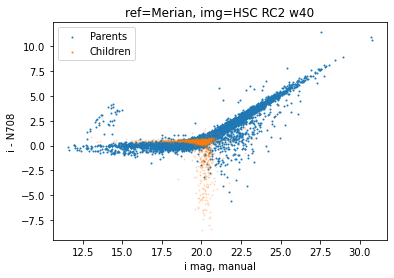

In [139]:
plt.scatter(30 - 2.5 * np.log10(cat[flag]['base_PsfFlux'].value * 57.543993733715425), 
            -2.5 * np.log10(cat[flag]['base_PsfFlux'].value / cat[flag]['N708_psfFlux']), 
            s=1, label='Parents')

plt.scatter(30 - 2.5 * np.log10(cat[~flag]['base_PsfFlux'].value * 57.543993733715425), 
            -2.5 * np.log10(cat[~flag]['base_PsfFlux'].value / cat[~flag]['N708_psfFlux']), 
            s=1, alpha=0.2, label='Children')

# plt.xlim(15, 27)
# plt.ylim(-1, 1)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

Text(0.5, 1.0, 'ref=Merian, img=HSC RC2 w40')

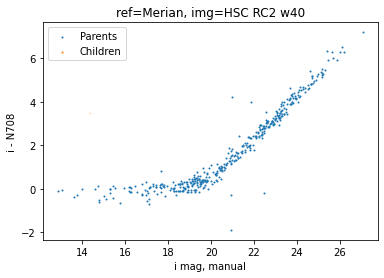

In [123]:
plt.scatter(30 - 2.5 * np.log10(cat[flag]['base_PsfFlux'].value * 57.543993733715425), 
            -2.5 * np.log10(cat[flag]['base_PsfFlux'].value / cat[flag]['N708_psfFlux']), 
            s=1, label='Parents')

plt.scatter(30 - 2.5 * np.log10(cat[~flag]['base_PsfFlux'].value * 57.543993733715425), 
            -2.5 * np.log10(cat[~flag]['base_PsfFlux'].value / cat[~flag]['N708_psfFlux']), 
            s=1, alpha=0.2, label='Children')

# plt.xlim(15, 27)
# plt.ylim(-1, 1)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel('i mag, manual')
plt.ylabel('i - N708')
plt.title('ref=Merian, img=HSC RC2 w40')

In [124]:
photTask.log.name

'lsst.forcedPhotCoadd'

rsync -zva --progress jiaxuanl@tiger.princeton.edu://projects/MERIAN/repo/S20A/gaapTable/9813/gaap_9813_23_Merian_RC2_i.fits ./

In [48]:
cat = hstack([cat_ref, cat2])
cat.write('/projects/MERIAN/repo/S20A/gaapTable/9813/gaap_9813_23_Merian_RC2_i.fits')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

plt.xlim(16, 25)
# plt.ylim(-0.5, 0.5)
# plt.ylim(-0.2, 0.2)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

Text(0, 0.5, 'Delta(i), manual - RC2')

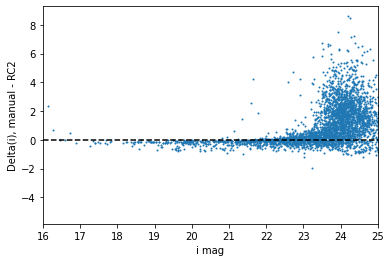

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

plt.xlim(16, 25)
# plt.ylim(-0.5, 0.5)
# plt.ylim(-0.2, 0.2)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

Text(0, 0.5, 'Delta(i), manual - RC2')

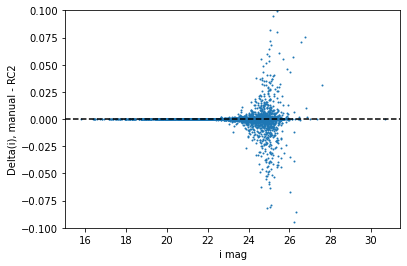

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

# plt.xlim(20, 29)
plt.ylim(-0.1, 0.1)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

In [54]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom

In [69]:
recordId = 60
shape = refCat[recordId].getShape()
shape

Quadrupole(ixx=5.69696065935947, iyy=10.230402632241299, ixy=0.6010893686853381)

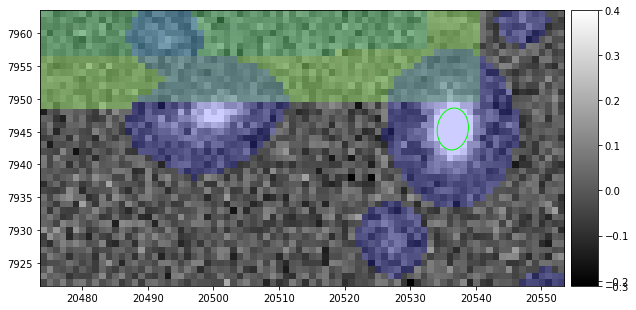

In [70]:
afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
display.setMaskTransparency(80)

obj = refCatInBand[recordId]
footprint = obj.getFootprint()
bbox = footprint.getBBox()
cutout = exposure[bbox]
display.mtv(cutout)
display.dot(shape, *obj.getCentroid()) #*bbox.getCenter())
# ax[1].set_title(f"recordId = {recordId}")

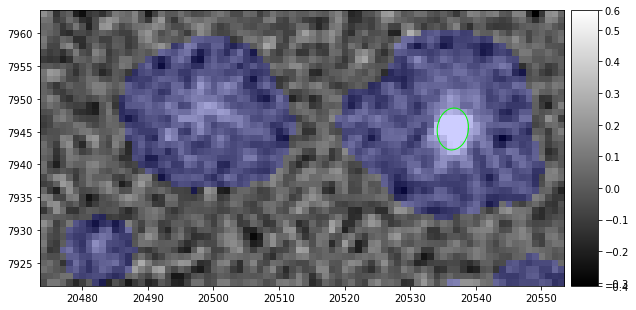

In [71]:
afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots(figsize=(10, 10))
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
display.setMaskTransparency(80)

obj = refCatInBand[recordId]
footprint = obj.getFootprint()
bbox = footprint.getBBox()
cutout = refExposure[bbox]
display.mtv(cutout)
display.dot(shape, *obj.getCentroid()) #*bbox.getCenter())
# ax[1].set_title(f"recordId = {recordId}")